<a href="https://colab.research.google.com/github/aniket-alt/CMPE-258-Deep-Learning/blob/main/Assignment%20-%203/colab_b_pytorch_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab b) 3-Layer Deep Neural Network using PyTorch from Scratch

**CMPE 258 - Deep Learning Assignment**

## Objective
Implement a 3-layer deep neural network for non-linear regression using **PyTorch from scratch** - without using `nn.Module`, `nn.Linear`, or any built-in layer functionality.

### What "from scratch" means here:
- Manual weight/bias tensor creation with `torch.randn`
- Manual forward pass using basic tensor operations
- Using PyTorch's autograd for automatic gradient computation
- Manual parameter updates (gradient descent)

## Target Function
$$y = \sin(x_1) \cdot \cos(x_2) + x_3^2 + 0.5 \cdot x_1 \cdot x_2$$

## Network Architecture
```
Input (3) → Hidden1 (64, Tanh) → Hidden2 (32, Tanh) → Output (1)
```

## 1. Import Libraries and Setup

We import PyTorch for tensor operations and automatic differentiation. We also check for GPU availability to accelerate training.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cu128
Using device: cuda
GPU: Tesla T4


## 2. Define the Target Non-Linear Function

This is the ground truth function our neural network will learn to approximate. We implement it using PyTorch tensors for GPU compatibility.

In [3]:
def target_function(x1, x2, x3):
    """
    Non-linear target function with 3 variables:
    y = sin(x1) * cos(x2) + x3^2 + 0.5 * x1 * x2

    Works with both numpy arrays and torch tensors.
    """
    if isinstance(x1, torch.Tensor):
        return torch.sin(x1) * torch.cos(x2) + x3**2 + 0.5 * x1 * x2
    else:
        return np.sin(x1) * np.cos(x2) + x3**2 + 0.5 * x1 * x2

# Test the function with both numpy and torch
print("NumPy test: f(1, 1, 1) =", target_function(1.0, 1.0, 1.0))
print("Torch test: f(1, 1, 1) =", target_function(
    torch.tensor(1.0), torch.tensor(1.0), torch.tensor(1.0)).item())

NumPy test: f(1, 1, 1) = 1.954648713412841
Torch test: f(1, 1, 1) = 1.954648733139038


## 3. Generate Synthetic Training Data

We create synthetic data and convert it to PyTorch tensors. The data is moved to the appropriate device (CPU or GPU).

In [4]:
def generate_data(n_samples=2000, noise_std=0.05, device='cpu'):
    """
    Generate synthetic data for training and testing.

    Args:
        n_samples: Number of data points to generate
        noise_std: Standard deviation of Gaussian noise
        device: 'cpu' or 'cuda'

    Returns:
        X: Input features tensor of shape (n_samples, 3)
        y: Target values tensor of shape (n_samples, 1)
    """
    # Generate random inputs in range [-2, 2]
    x1 = np.random.uniform(-2, 2, n_samples)
    x2 = np.random.uniform(-2, 2, n_samples)
    x3 = np.random.uniform(-2, 2, n_samples)

    # Stack into feature matrix
    X = np.column_stack([x1, x2, x3]).astype(np.float32)

    # Compute target values with noise
    y = target_function(x1, x2, x3) + np.random.normal(0, noise_std, n_samples)
    y = y.reshape(-1, 1).astype(np.float32)

    # Convert to PyTorch tensors and move to device
    X_tensor = torch.tensor(X, device=device)
    y_tensor = torch.tensor(y, device=device)

    return X_tensor, y_tensor

# Generate training and test data
X_train, y_train = generate_data(n_samples=2000, device=device)
X_test, y_test = generate_data(n_samples=500, device=device)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")
print(f"Data device: {X_train.device}")
print(f"\nSample input (first 3 rows):")
print(X_train[:3].cpu().numpy())
print(f"\nSample output (first 3 values):")
print(y_train[:3].cpu().numpy().flatten())

Training data shape: X=torch.Size([2000, 3]), y=torch.Size([2000, 1])
Test data shape: X=torch.Size([500, 3]), y=torch.Size([500, 1])
Data device: cuda:0

Sample input (first 3 rows):
[[-0.5018395 -0.9531773  0.2879835]
 [ 1.8028573 -1.0120848  1.2217293]
 [ 0.9279758  1.6250184  1.0406437]]

Sample output (first 3 values):
[-0.0087682  1.1198553  1.8080971]


## 4. Initialize Network Parameters (From Scratch)

This is the key part of "from scratch" implementation. We manually create weight and bias tensors using `torch.randn`. We use Xavier initialization and set `requires_grad=True` to enable automatic gradient computation.

In [20]:
def initialize_parameters(input_size=3, hidden1_size=64, hidden2_size=32, output_size=1, device='cpu'):
    """
    Initialize neural network parameters manually.
    """
    params = {}

    # Layer 1: Input -> Hidden1
    scale1 = np.sqrt(2.0 / (input_size + hidden1_size))
    W1 = torch.randn(input_size, hidden1_size, device=device) * scale1
    params['W1'] = W1.clone().detach().requires_grad_(True)
    params['b1'] = torch.zeros(1, hidden1_size, device=device, requires_grad=True)

    # Layer 2: Hidden1 -> Hidden2
    scale2 = np.sqrt(2.0 / (hidden1_size + hidden2_size))
    W2 = torch.randn(hidden1_size, hidden2_size, device=device) * scale2
    params['W2'] = W2.clone().detach().requires_grad_(True)
    params['b2'] = torch.zeros(1, hidden2_size, device=device, requires_grad=True)

    # Layer 3: Hidden2 -> Output
    scale3 = np.sqrt(2.0 / (hidden2_size + output_size))
    W3 = torch.randn(hidden2_size, output_size, device=device) * scale3
    params['W3'] = W3.clone().detach().requires_grad_(True)
    params['b3'] = torch.zeros(1, output_size, device=device, requires_grad=True)

    print("Network Parameters Initialized:")
    print(f"  W1: {params['W1'].shape}, b1: {params['b1'].shape}")
    print(f"  W2: {params['W2'].shape}, b2: {params['b2'].shape}")
    print(f"  W3: {params['W3'].shape}, b3: {params['b3'].shape}")

    return params

# Initialize parameters
params = initialize_parameters(device=device)

Network Parameters Initialized:
  W1: torch.Size([3, 64]), b1: torch.Size([1, 64])
  W2: torch.Size([64, 32]), b2: torch.Size([1, 32])
  W3: torch.Size([32, 1]), b3: torch.Size([1, 1])


## 5. Define Forward Pass (From Scratch)

The forward pass computes predictions by passing input through each layer sequentially. We manually implement the linear transformation (`X @ W + b`) and activation functions using basic PyTorch tensor operations.

In [21]:
def forward(X, params):
    """
    Forward propagation through the network (from scratch).

    Computes: y = W3 @ tanh(W2 @ tanh(W1 @ X + b1) + b2) + b3

    Args:
        X: Input tensor of shape (batch_size, input_size)
        params: Dictionary containing W1, b1, W2, b2, W3, b3

    Returns:
        output: Predictions of shape (batch_size, output_size)
        cache: Dictionary of intermediate activations (for debugging)
    """
    cache = {}

    # Layer 1: Linear + Tanh
    # z1 = X @ W1 + b1 (using torch.mm for matrix multiplication)
    z1 = torch.mm(X, params['W1']) + params['b1']
    a1 = torch.tanh(z1)  # Tanh activation
    cache['z1'], cache['a1'] = z1, a1

    # Layer 2: Linear + Tanh
    z2 = torch.mm(a1, params['W2']) + params['b2']
    a2 = torch.tanh(z2)
    cache['z2'], cache['a2'] = z2, a2

    # Layer 3: Linear (no activation for regression output)
    z3 = torch.mm(a2, params['W3']) + params['b3']
    output = z3  # Linear output
    cache['z3'] = z3

    return output, cache

# Test forward pass
test_output, _ = forward(X_train[:5], params)
print("Forward pass test:")
print(f"  Input shape: {X_train[:5].shape}")
print(f"  Output shape: {test_output.shape}")
print(f"  Sample outputs: {test_output.detach().cpu().numpy().flatten()}")

Forward pass test:
  Input shape: torch.Size([5, 3])
  Output shape: torch.Size([5, 1])
  Sample outputs: [ 0.19483316 -0.51491374 -0.78005135  0.5420402   0.8298339 ]


## 6. Define Loss Function

We use Mean Squared Error (MSE) loss for this regression task. The loss is computed manually without using `nn.MSELoss`.

In [22]:
def compute_mse_loss(y_pred, y_true):
    """
    Compute Mean Squared Error loss manually.

    MSE = (1/n) * sum((y_pred - y_true)^2)

    Args:
        y_pred: Predicted values
        y_true: Ground truth values

    Returns:
        loss: Scalar MSE loss value
    """
    return torch.mean((y_pred - y_true) ** 2)

# Test loss computation
test_loss = compute_mse_loss(test_output, y_train[:5])
print(f"Test MSE loss: {test_loss.item():.6f}")

Test MSE loss: 2.546199


## 7. Training Loop with Manual Gradient Descent

This is where we bring everything together:
1. **Forward pass**: Compute predictions
2. **Compute loss**: MSE between predictions and targets
3. **Backward pass**: Use `loss.backward()` to compute gradients automatically
4. **Update parameters**: Manual gradient descent step
5. **Zero gradients**: Clear gradients for next iteration

Note: We use PyTorch's autograd for gradient computation, but parameter updates are done manually without an optimizer.

In [23]:
def train_network(params, X_train, y_train, X_test, y_test,
                  epochs=1000, learning_rate=0.01, print_every=100):
    """
    Train the neural network using gradient descent (from scratch).
    """
    train_losses = []
    test_losses = []

    print(f"Starting training for {epochs} epochs with learning rate {learning_rate}")
    print("=" * 60)

    for epoch in range(epochs):
        # ========== FORWARD PASS ==========
        y_pred, _ = forward(X_train, params)

        # ========== COMPUTE LOSS ==========
        loss = compute_mse_loss(y_pred, y_train)
        train_losses.append(loss.item())

        # ========== BACKWARD PASS ==========
        loss.backward()

        # ========== MANUAL PARAMETER UPDATE ==========
        with torch.no_grad():
            for key in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']:
                # Use .data to update without tracking gradients
                params[key].data -= learning_rate * params[key].grad.data
                # Zero gradients for next iteration
                params[key].grad.data.zero_()

        # ========== COMPUTE TEST LOSS ==========
        with torch.no_grad():
            y_pred_test, _ = forward(X_test, params)
            test_loss = compute_mse_loss(y_pred_test, y_test)
            test_losses.append(test_loss.item())

        # Print progress
        if (epoch + 1) % print_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1:4d}/{epochs} | "
                  f"Train Loss: {train_losses[-1]:.6f} | "
                  f"Test Loss: {test_losses[-1]:.6f}")

    print("=" * 60)
    print(f"Training complete!")
    print(f"Final Train Loss: {train_losses[-1]:.6f}")
    print(f"Final Test Loss: {test_losses[-1]:.6f}")

    return params, train_losses, test_losses

params, train_losses, test_losses = train_network(
    params, X_train, y_train, X_test, y_test,
    epochs=1000,
    learning_rate=0.05,
    print_every=100
)

Starting training for 1000 epochs with learning rate 0.05
Epoch    1/1000 | Train Loss: 4.184892 | Test Loss: 2.610036
Epoch  100/1000 | Train Loss: 0.730161 | Test Loss: 0.739467
Epoch  200/1000 | Train Loss: 0.138503 | Test Loss: 0.145250
Epoch  300/1000 | Train Loss: 0.069727 | Test Loss: 0.071933
Epoch  400/1000 | Train Loss: 0.050801 | Test Loss: 0.050776
Epoch  500/1000 | Train Loss: 0.048580 | Test Loss: 0.047408
Epoch  600/1000 | Train Loss: 0.273681 | Test Loss: 0.247737
Epoch  700/1000 | Train Loss: 0.155773 | Test Loss: 0.167650
Epoch  800/1000 | Train Loss: 0.066329 | Test Loss: 0.072080
Epoch  900/1000 | Train Loss: 0.043390 | Test Loss: 0.046205
Epoch 1000/1000 | Train Loss: 0.039947 | Test Loss: 0.041998
Training complete!
Final Train Loss: 0.039947
Final Test Loss: 0.041998


## 8. Visualize Training Progress

We plot the training and test loss curves to visualize the learning progress and check for overfitting.

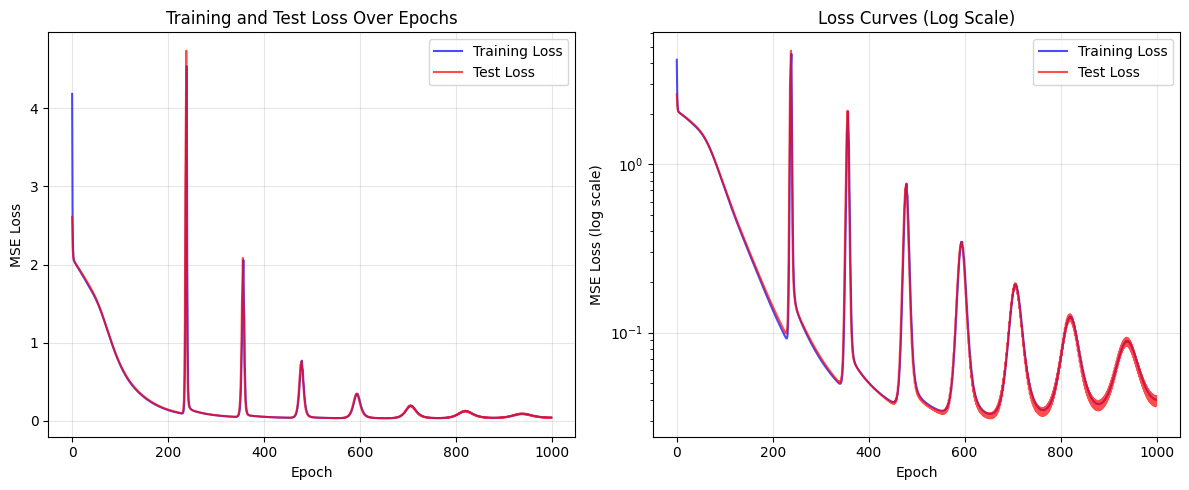

In [24]:
def plot_loss_curves(train_losses, test_losses):
    """
    Plot training and test loss curves.
    """
    plt.figure(figsize=(12, 5))

    # Plot 1: Full loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Log scale
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(test_losses, label='Test Loss', color='red', alpha=0.7)
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss (log scale)')
    plt.title('Loss Curves (Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_loss_curves(train_losses, test_losses)

## 9. Evaluate Model Performance

We evaluate the trained model using various metrics and visualize the predictions against actual values.

Model Evaluation Metrics:
  MSE (Mean Squared Error):  0.041998
  RMSE (Root MSE):           0.204934
  MAE (Mean Absolute Error): 0.163455
  R² Score:                  0.980032


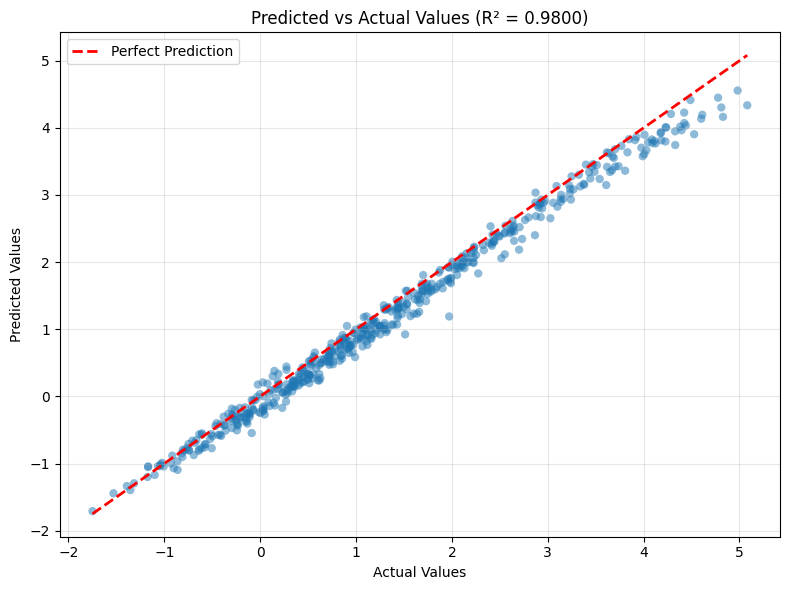

In [25]:
def evaluate_model(params, X_test, y_test):
    """
    Evaluate model performance with various metrics.
    """
    with torch.no_grad():
        y_pred, _ = forward(X_test, params)

    # Convert to numpy for metrics
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Calculate metrics
    mse = np.mean((y_pred_np - y_test_np)**2)
    mae = np.mean(np.abs(y_pred_np - y_test_np))
    rmse = np.sqrt(mse)

    # R-squared score
    ss_res = np.sum((y_test_np - y_pred_np)**2)
    ss_tot = np.sum((y_test_np - np.mean(y_test_np))**2)
    r2 = 1 - (ss_res / ss_tot)

    print("Model Evaluation Metrics:")
    print(f"  MSE (Mean Squared Error):  {mse:.6f}")
    print(f"  RMSE (Root MSE):           {rmse:.6f}")
    print(f"  MAE (Mean Absolute Error): {mae:.6f}")
    print(f"  R² Score:                  {r2:.6f}")

    # Scatter plot of predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_np, y_pred_np, alpha=0.5, edgecolors='none')
    plt.plot([y_test_np.min(), y_test_np.max()],
             [y_test_np.min(), y_test_np.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return y_pred_np, y_test_np

y_pred_np, y_test_np = evaluate_model(params, X_test, y_test)

## 10. 4D Visualization

We create visualizations to show the relationship between the 3 input variables and the predicted output.

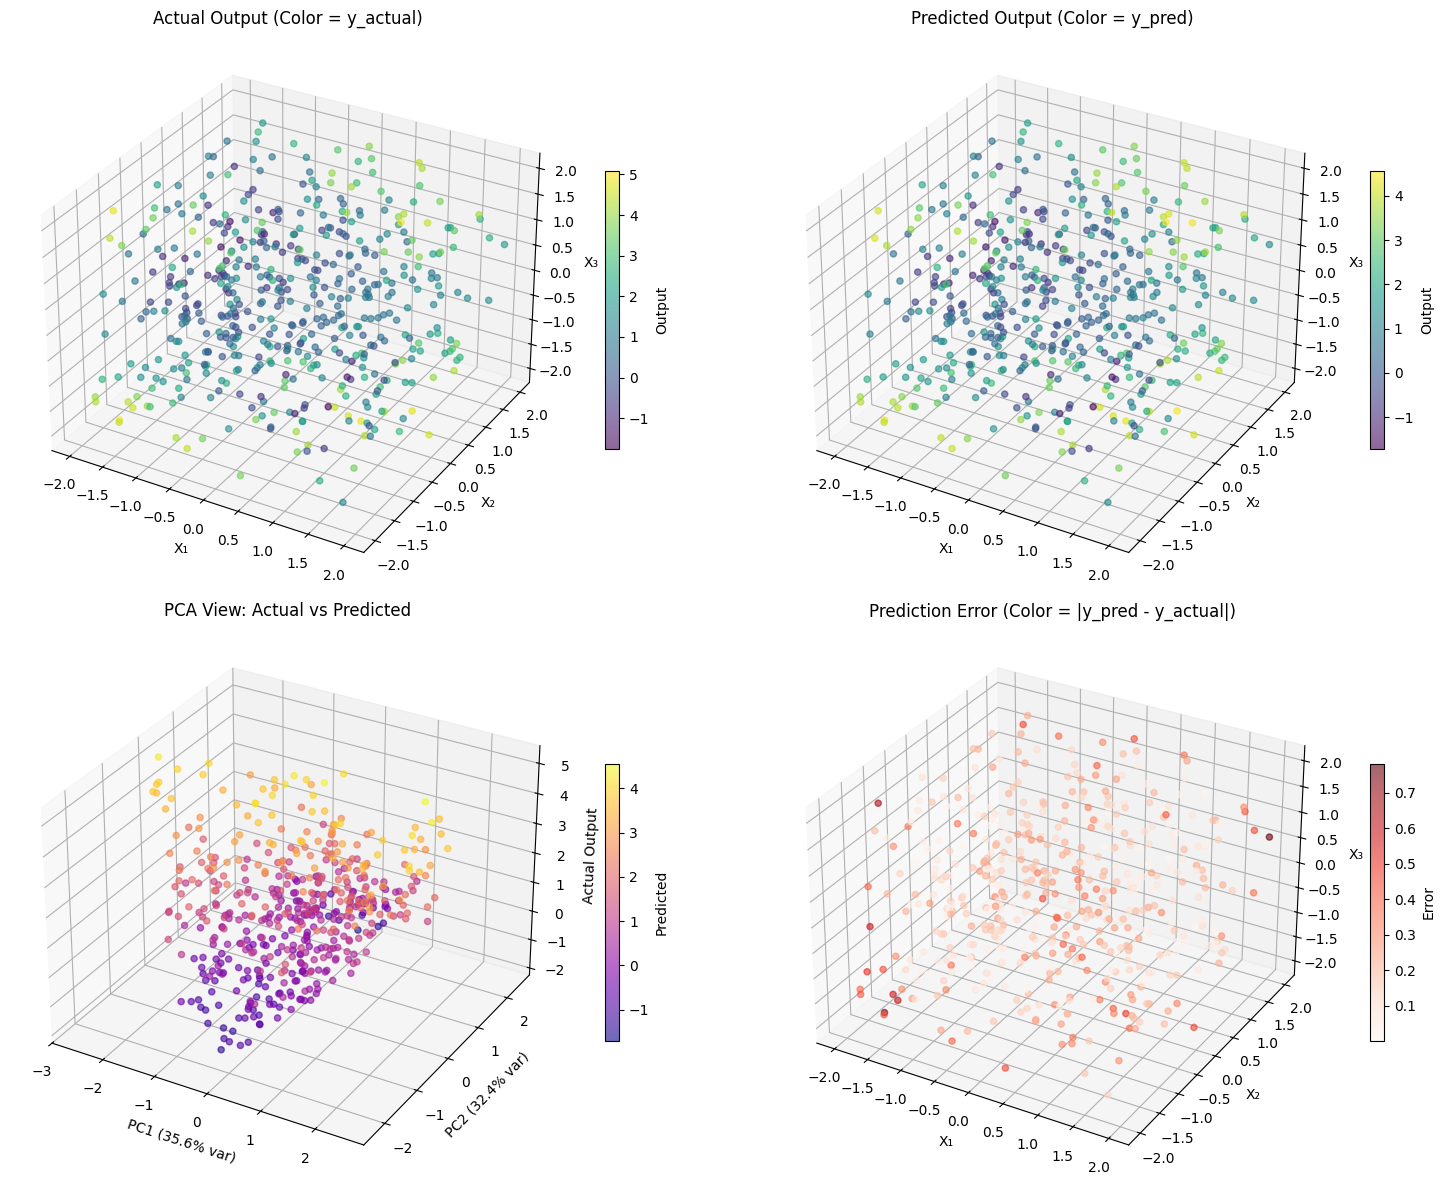


PCA Explained Variance Ratio: [0.35560745 0.32382295]
Total Variance Explained: 67.9%


In [26]:
def plot_4d_visualization(params, X_test, y_test):
    """
    Create 4D visualizations of the neural network predictions.
    """
    with torch.no_grad():
        y_pred, _ = forward(X_test, params)

    # Convert to numpy
    X_np = X_test.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy().flatten()
    y_actual_np = y_test.cpu().numpy().flatten()

    fig = plt.figure(figsize=(16, 12))

    # ===== Plot 1: Direct 3D with color for actual output =====
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=y_actual_np, cmap='viridis', alpha=0.6, s=20)
    ax1.set_xlabel('X₁')
    ax1.set_ylabel('X₂')
    ax1.set_zlabel('X₃')
    ax1.set_title('Actual Output (Color = y_actual)')
    plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Output')

    # ===== Plot 2: Direct 3D with color for predicted output =====
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=y_pred_np, cmap='viridis', alpha=0.6, s=20)
    ax2.set_xlabel('X₁')
    ax2.set_ylabel('X₂')
    ax2.set_zlabel('X₃')
    ax2.set_title('Predicted Output (Color = y_pred)')
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Output')

    # ===== Plot 3: PCA-based visualization =====
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_np)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], y_actual_np,
                          c=y_pred_np, cmap='plasma', alpha=0.6, s=20)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
    ax3.set_zlabel('Actual Output')
    ax3.set_title('PCA View: Actual vs Predicted')
    plt.colorbar(scatter3, ax=ax3, shrink=0.5, label='Predicted')

    # ===== Plot 4: Prediction Error Visualization =====
    error = np.abs(y_pred_np - y_actual_np)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    scatter4 = ax4.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2],
                          c=error, cmap='Reds', alpha=0.6, s=20)
    ax4.set_xlabel('X₁')
    ax4.set_ylabel('X₂')
    ax4.set_zlabel('X₃')
    ax4.set_title('Prediction Error (Color = |y_pred - y_actual|)')
    plt.colorbar(scatter4, ax=ax4, shrink=0.5, label='Error')

    plt.tight_layout()
    plt.savefig('4d_visualization_pytorch.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPCA Explained Variance Ratio: {pca.explained_variance_ratio_}")
    print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.1%}")

plot_4d_visualization(params, X_test, y_test)

## 11. Summary and Key Takeaways

### What "From Scratch" Means in This Notebook:

| Component | Implementation |
|-----------|---------------|
| Weight Initialization | `torch.randn()` with Xavier scaling |
| Forward Pass | Manual `torch.mm()` + `torch.tanh()` |
| Loss Function | Manual MSE computation |
| Backward Pass | PyTorch autograd (`loss.backward()`) |
| Parameter Update | Manual gradient descent |

### What We Did NOT Use:
- ❌ `nn.Module`
- ❌ `nn.Linear`
- ❌ `nn.Sequential`
- ❌ `torch.optim` optimizers
- ❌ `nn.MSELoss`

### Key Difference from NumPy Version:
- We used PyTorch's autograd for automatic gradient computation instead of manual chain rule
- This demonstrates PyTorch's power while still understanding low-level operations

In [27]:
# Final summary
print("=" * 60)
print("COLAB B - PYTORCH FROM SCRATCH IMPLEMENTATION SUMMARY")
print("=" * 60)
print(f"\nTarget Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂")
print(f"\nArchitecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)")
print(f"\nTraining Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Device: {device}")
print(f"\nFinal Training Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"\nKey Features:")
print("  ✓ Manual weight initialization (torch.randn)")
print("  ✓ Manual forward pass (torch.mm, torch.tanh)")
print("  ✓ Manual loss computation")
print("  ✓ Autograd for gradients (loss.backward)")
print("  ✓ Manual parameter updates (no optimizer)")
print("  ✓ NO nn.Module, nn.Linear, or nn.Sequential used")
print("=" * 60)

COLAB B - PYTORCH FROM SCRATCH IMPLEMENTATION SUMMARY

Target Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂

Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)

Training Samples: 2000
Test Samples: 500
Device: cuda

Final Training Loss: 0.039947
Final Test Loss: 0.041998

Key Features:
  ✓ Manual weight initialization (torch.randn)
  ✓ Manual forward pass (torch.mm, torch.tanh)
  ✓ Manual loss computation
  ✓ Autograd for gradients (loss.backward)
  ✓ Manual parameter updates (no optimizer)
  ✓ NO nn.Module, nn.Linear, or nn.Sequential used
